<a href="https://colab.research.google.com/github/Asmaa-yb/ML-pour-la-Pr-vision-des-Ventes-Multinproduits/blob/main/Demand%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Importation des librairies:**

Dans cette première étape, les librairies nécessaires à l'analyse sont importées. Pandas est utilisé pour la manipulation des données, NumPy pour les opérations numériques, Matplotlib et Seaborn pour la visualisation, et Scikit-learn pour le machine learning.

In [182]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

**2. Chargement des données:**

Les données d'entraînement et de test sont chargées à partir de fichiers CSV à l'aide de la fonction read_csv de Pandas. Les DataFrames résultants sont nommés df_train et df_test.

In [158]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv('/content/test.csv')

**3. Vérification des valeurs manquantes:**

La méthode `isnull().sum()` est utilisée pour vérifier le nombre de valeurs manquantes dans chaque colonne des DataFrames d'entraînement et de test.

Et puis la méthode `head()` est utilisée pour afficher les premières lignes des DataFrames d'entraînement et de test, ce qui permet d'avoir un aperçu des données.

In [159]:
df_train.isnull().sum()

,0
date,0
store,0
item,0
sales,0


In [160]:
df_test.isnull().sum()

,0
id,0
date,0
store,0
item,0


In [161]:
df_train.head(2)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11


In [162]:
df_test.head(2)

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1


**4. Visualisation de la distribution des données:**

La méthode` hist()` est utilisée pour créer des histogrammes de toutes les colonnes numériques des DataFrames d'entraînement et de test. Cela permet de visualiser la distribution de chaque variable.

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'item'}>],
       [<Axes: title={'center': 'sales'}>, <Axes: >]], dtype=object)

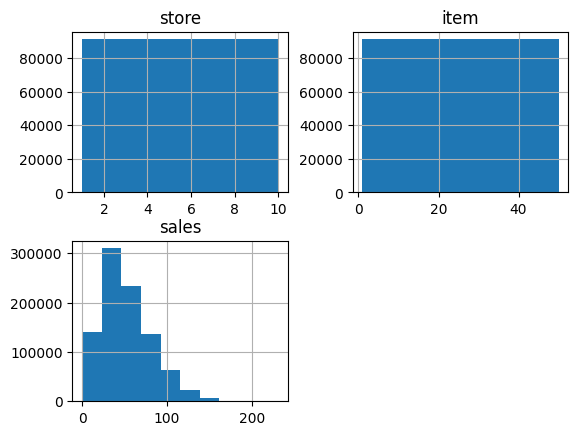

In [163]:
df_train.hist()

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'store'}>],
       [<Axes: title={'center': 'item'}>, <Axes: >]], dtype=object)

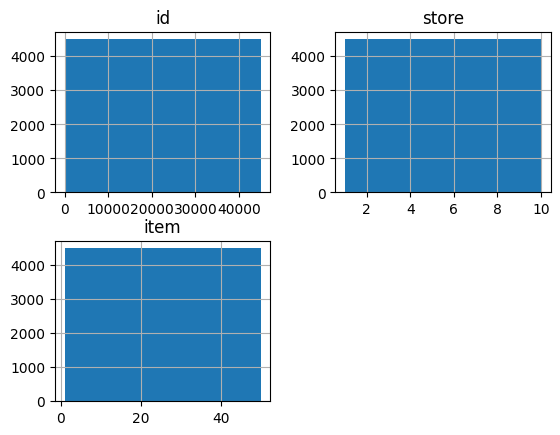

In [164]:
df_test.hist()

**5. Visualisation de la distribution des ventes:**

Un histogramme de la colonne '**sales**' du DataFrame d'entraînement est créé à l'aide de la fonction `distplot` de Seaborn. Cela permet de visualiser la distribution des ventes.

<ipython-input-165-80c323f30957>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_train['sales'])


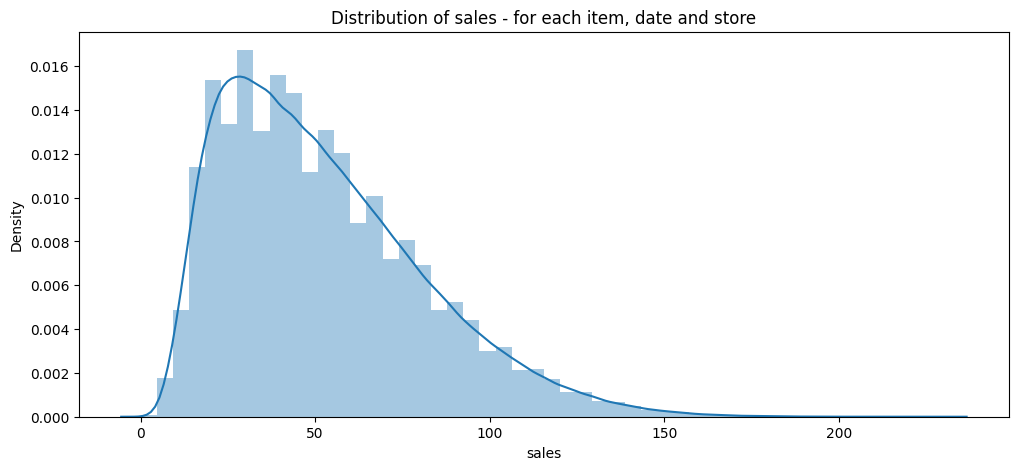

In [165]:
plt.figure(figsize=(12,5))
plt.title("Distribution of sales - for each item, date and store")
ax = sns.distplot(df_train['sales'])


**Tendances des magasins**

Ici, nous cherchons à voir s'il existe des tendances saisonnières dans les ventes totales des magasins. Nous allons grouper par semaine afin de mieux visualiser les tendances dans les graphiques.

In [197]:
df = pd.read_csv('/content/1train.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.tail()

,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [198]:
stores = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)

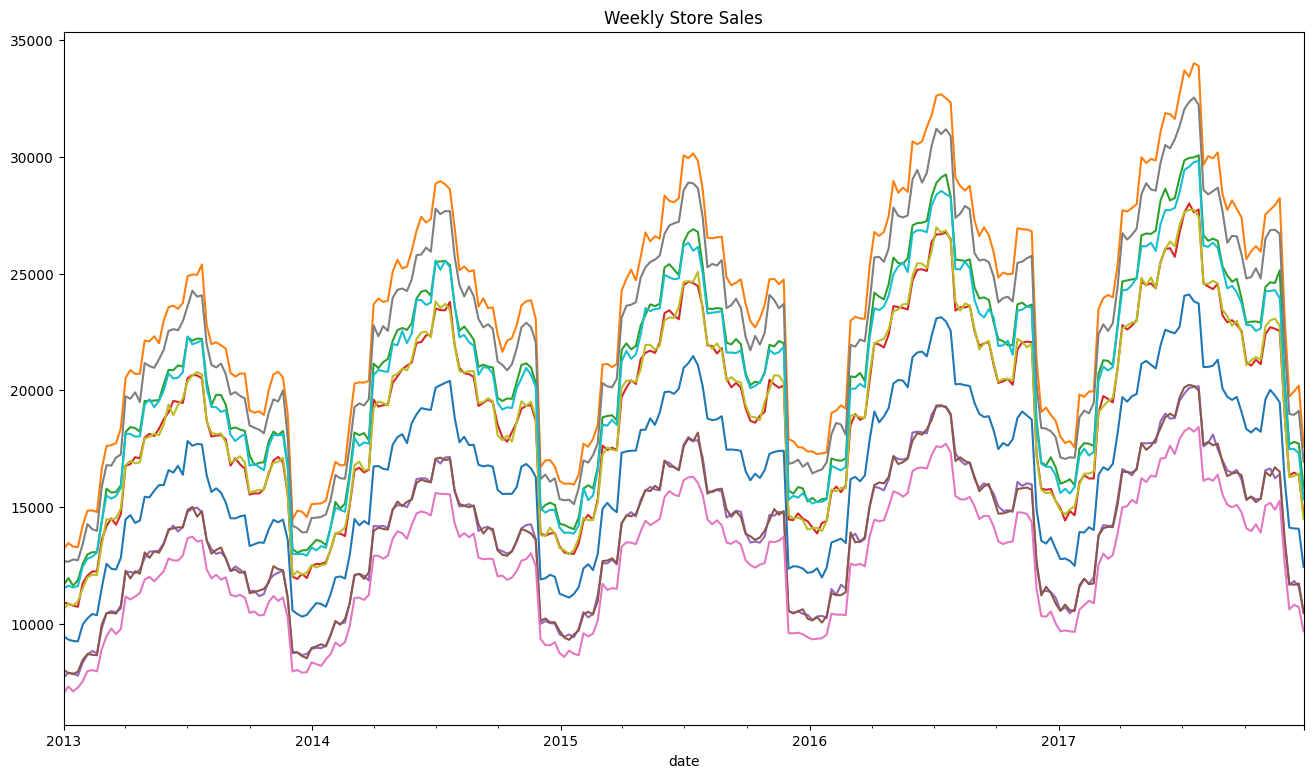

In [199]:
stores.plot(figsize=(16,9), title='Weekly Store Sales', legend=None)
plt.show()

Le graphique ci-dessus montre les ventes de chaque magasin par semaine. Mais comment la tendance moyenne évolue-t-elle ? Et la tranche des 25 % ?

Voyons cela :

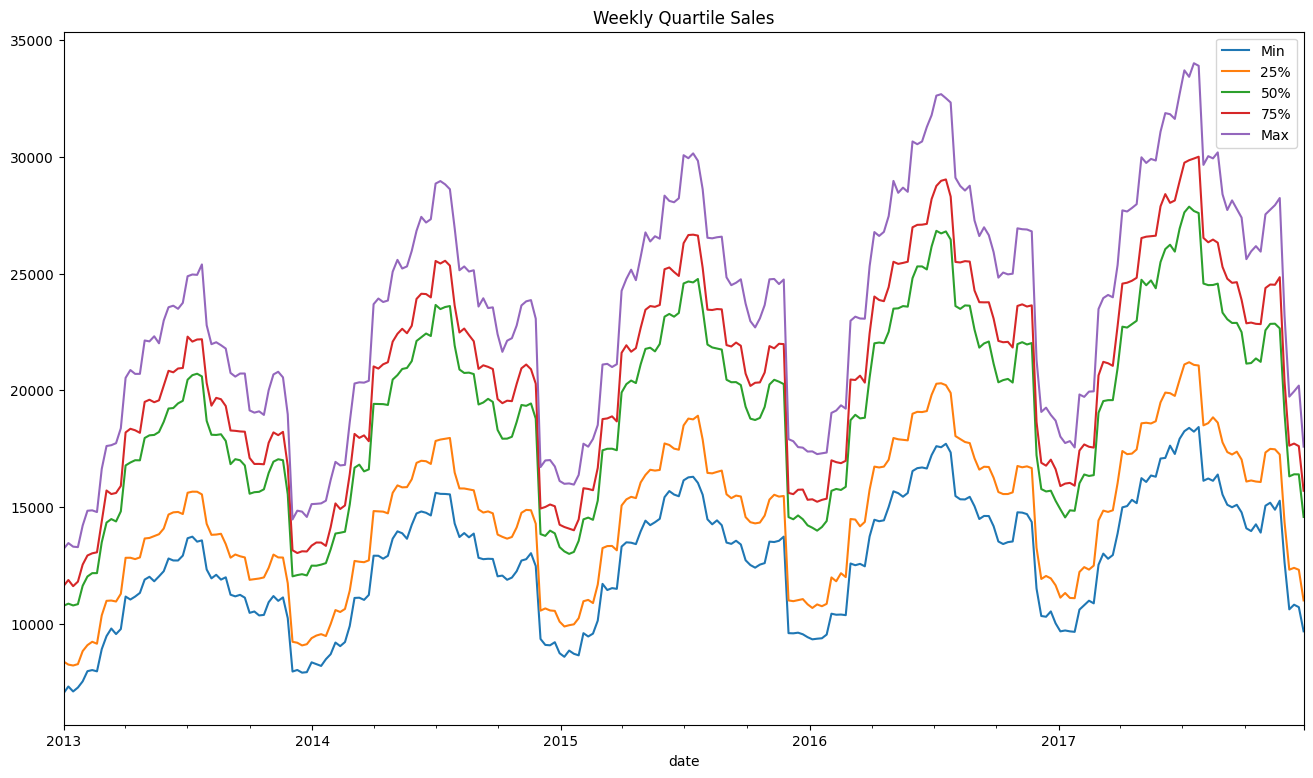

In [200]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

Nous pouvons voir qu'il y a un écart assez important entre le quartile des 25 % et la moyenne. Cependant, comme le montre également l'autre graphique, chaque magasin suit une saisonnalité générale. Ils connaissent des pics et des creux pendant les mêmes périodes.

Examinons maintenant l'aspect saisonnier de la moyenne. Mais avant cela, nous allons suivre la différence d'une semaine à l'autre.

In [203]:
from statsmodels.tsa.seasonal import seasonal_decompose

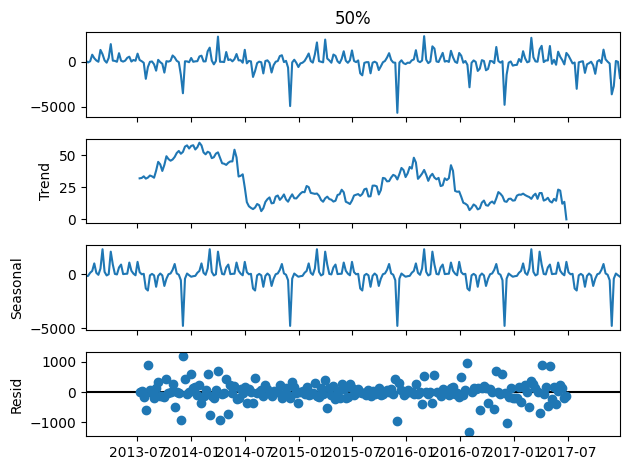

In [204]:
seasonal = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

**Tendances des ventes des articles**

Nous allons maintenant effectuer la même analyse pour les ventes totales des articles. Encore une fois, nous observons les ventes hebdomadaires.

In [208]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0])

# Afficher les résultats du test ADF
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -5.965888844671847
p-value: 1.9882919872267362e-07
Critical Values: {'1%': -3.4561550092339512, '5%': -2.8728972266578676, '10%': -2.5728222369384763}


In [210]:
items = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

items.tail(13)

sales                                                        ...  \
item          1     2     3     4     5     6     7     8     9     10  ...   
date                                                                    ...   
2017-10-03  1769  4471  2740  1677  1372  4515  4503  5842  3917  5573  ...   
2017-10-10  1758  4454  2858  1757  1392  4483  4510  5932  3861  5771  ...   
2017-10-17  1732  4481  2856  1700  1396  4470  4606  6016  3911  5752  ...   
2017-10-24  1662  4422  2767  1724  1456  4476  4478  6083  3873  5654  ...   
2017-10-31  1774  4798  3087  1680  1476  4766  4837  6415  4276  6088  ...   
2017-11-07  1735  4887  3143  1879  1540  4686  4867  6403  4335  6161  ...   
2017-11-14  1824  4812  3094  1816  1479  4882  4854  6439  4251  5965  ...   
2017-11-21  1818  4840  3076  1876  1576  4835  4936  6427  4181  6053  ...   
2017-11-28  1490  4042  2527  1509  1301  4137  3932  5415  3548  5108  ...   
2017-12-05  1311  3551  2182  1296  1179  3562  3522  4510  3018  4358  ...   
2017-12-12  1308  3498  2251  1277  1125  3541  3381  4699  3014  4372  ...   
2017-12-19  1262  3450  2181  1306  1085  3463  3477  4516  2971  4428  ...   
2017-12-26  1167  3180  1956  1150  1000  2973  3170  4065  2764  3722  ...   

                                                                        
item          41    42    43    44    45    46    47    48    49    50  
date                                                                    
2017-10-03  1629  2845  3963  2416  6089  4620  1696  3973  2285  5054  
2017-10-10  1741  2815  3892  2338  6213  4529  1644  3949  2208  4967  
2017-10-17  1619  2778  4005  2245  6198  4560  1700  3949  2260  5070  
2017-10-24  1644  2761  3927  2346  6404  4494  1739  4021  2202  5074  
2017-10-31  1817  3038  4318  2386  6623  4889  1798  4257  2468  5323  
2017-11-07  1764  3067  4358  2408  6711  4947  1820  4291  2417  5542  
2017-11-14  1807  3076  4315  2424  6774  4884  1755  4318  2475  5349  
2017-11-21  1872  2987  4273  2392  6530  4915  1860  4329  2364  5517  
2017-11-28  1610  2635  3529  2051  5524  4028  1591  3580  1991  4503  
2017-12-05  1280  2148  2985  1756  4695  3510  1283  3101  1669  3829  
2017-12-12  1349  2213  3100  1785  4721  3483  1279  3051  1701  3856  
2017-12-19  1240  2115  3162  1669  4772  3524  1361  3177  1689  3900  
2017-12-26  1124  1893  2680  1546  4349  3182  1166  2655  1546  3411  

[13 rows x 50 columns]

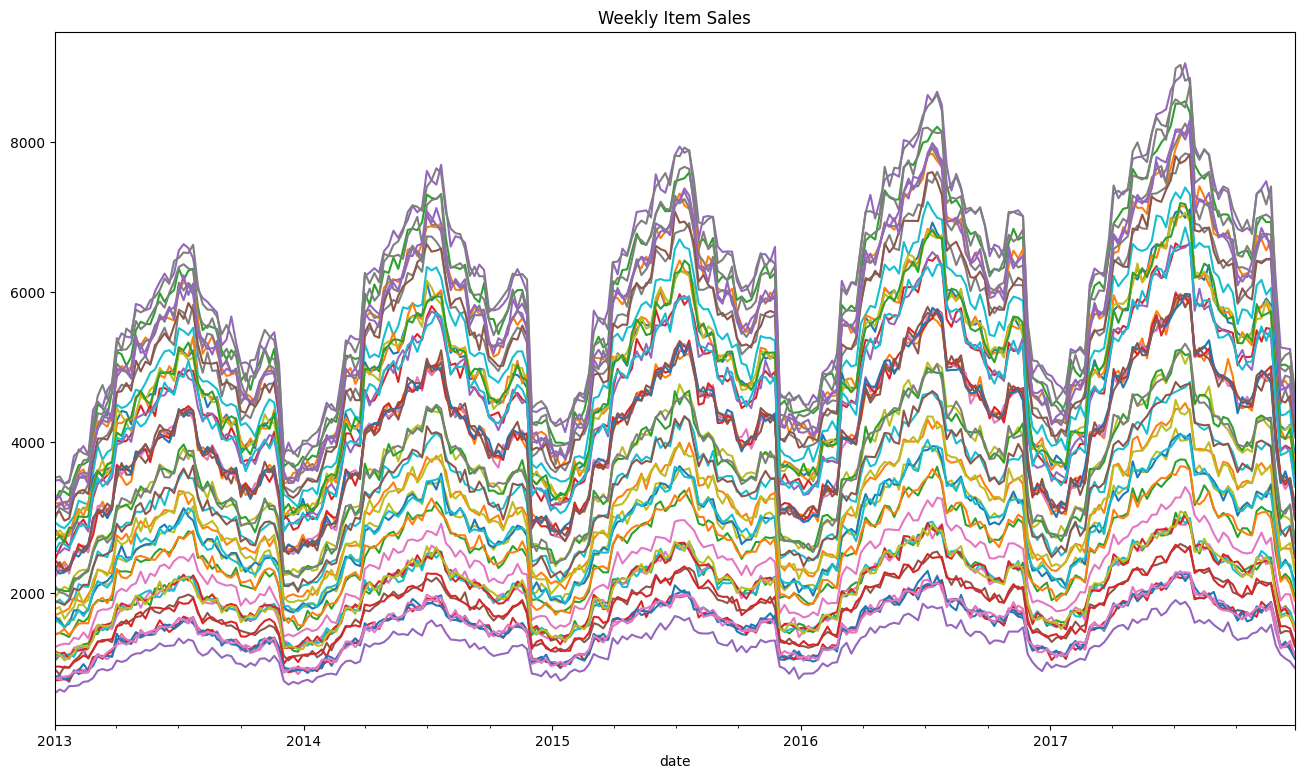

In [211]:
items.plot(figsize=(16,9), title='Weekly Item Sales', legend=None)
plt.show()

Étant donné qu'il y a plus d'articles que de magasins, nous pouvons examiner davantage de quartiles. Voyons comment chaque quartile de 10% évolue.

In [ ]:
item_WK_qtr = pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],axis=1)).transpose()
item_WK_qtr.sort_index(inplace = True)
item_WK_qtr.columns = ['Min','10%','20%','30%','40%','50%','60%','70%','80%','90%','Max']
item_WK_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()


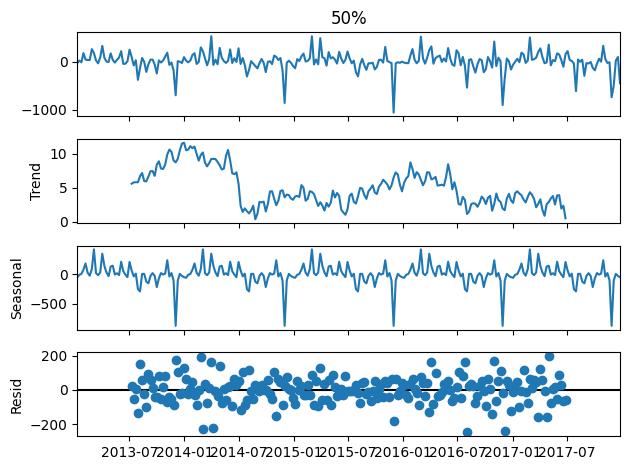

In [213]:
seasonal = seasonal_decompose(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.title = 'Additive Seasonal Decomposition of Average Item Week-to-Week Sales'
plt.show()


**Variabilité des Magasins et des Produits**

Nous avons vu comment les magasins et les produits évoluent de manière individuelle, mais est-ce que certains magasins vendent plus d'un produit particulier ? En d'autres termes, est-ce que les magasins ont le même mix de ventes ? Les produits sont-ils vendus de manière uniforme (en pourcentage) dans tous les magasins ?

Ci-dessous, un graphique montrant la distribution en pourcentage des ventes de chaque produit à travers les magasins (chaque ligne totalise 100 %). Comme nous pouvons le voir, la distribution est très uniforme. La conclusion ici est que les produits sont vendus de manière équitable dans tous les magasins.

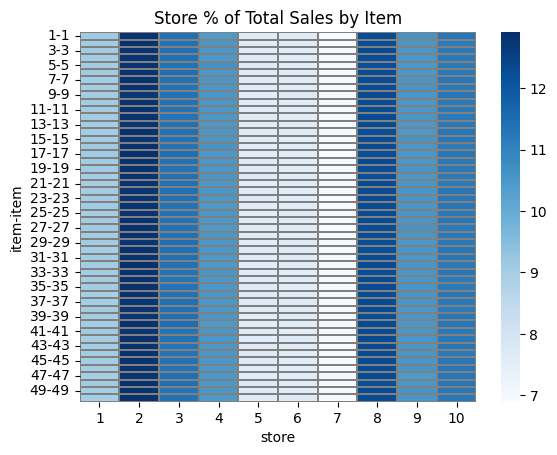

In [215]:
store_item = df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(store_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Store % of Total Sales by Item')
plt.show()


Maintenant, pour confirmer, examinons la distribution en pourcentage des ventes de chaque magasin à travers les différents produits (chaque ligne totalise 100 %).

Nous pouvons constater que chaque magasin a vendu environ le même pourcentage de chaque produit.

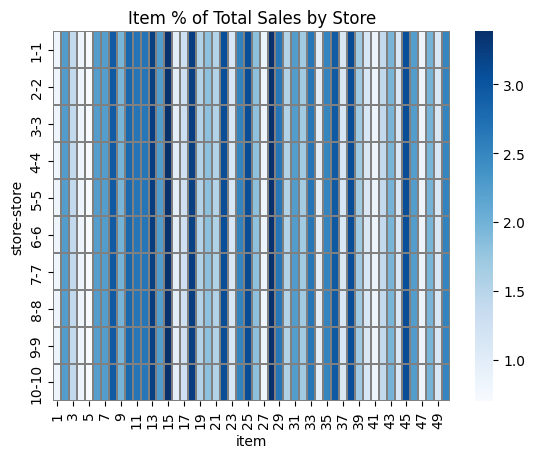

In [216]:
item_store = df.groupby(by=['store','item']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(item_store , cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Item % of Total Sales by Store')
plt.show()

**Variabilité selon le jour de la semaine **

Comment les ventes varient-elles en fonction du jour de la semaine ? Y a-t-il une saisonnalité ? Les magasins partagent-ils les mêmes tendances ?

In [219]:
df['Day'] = df.index.day_name()
df.head()

,store,item,sales,Day
date,,,,
2013-01-01,1,1,13,Tuesday
2013-01-02,1,1,11,Wednesday
2013-01-03,1,1,14,Thursday
2013-01-04,1,1,13,Friday
2013-01-05,1,1,10,Saturday


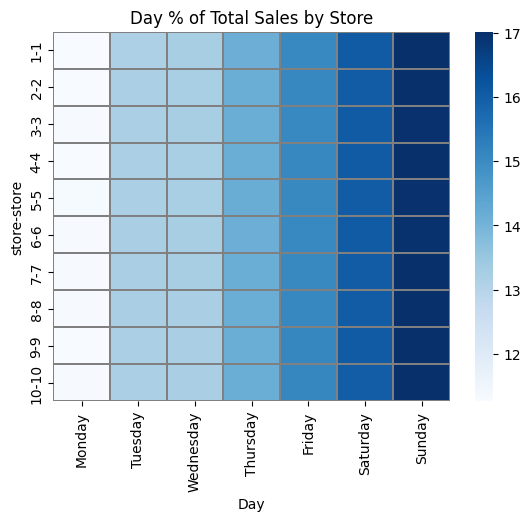

In [220]:
dow_store = df.groupby(['store','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_store, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Store')
plt.show()

Le graphique ci-dessus montre la répartition en pourcentage des ventes des magasins par jour. Nous pouvons voir que les magasins sont très similaires en termes de jours populaires.

Faisons la même chose pour les articles.

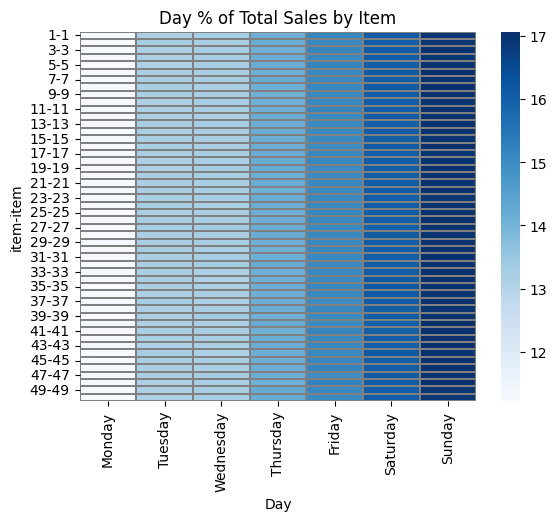

In [221]:
dow_item = df.groupby(['item','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Item')
plt.show()

Ce graphique nous indique que les ventes de chaque article sont presque identiques en termes de jours les plus populaires.

Voyons maintenant si chaque jour suit généralement la même tendance que la semaine totale.

In [222]:
dow = pd.DataFrame(df.groupby(['date','Day']).sum()['sales']).unstack()['sales'].loc[:,
                                                                                ['Monday',
                                                                               'Tuesday',
                                                                               'Wednesday',
                                                                               'Thursday',
                                                                               'Friday',
                                                                               'Saturday',
                                                                               'Sunday']]
dow = dow.resample('7D',label='left').sum()
dow.sort_index(inplace = True)

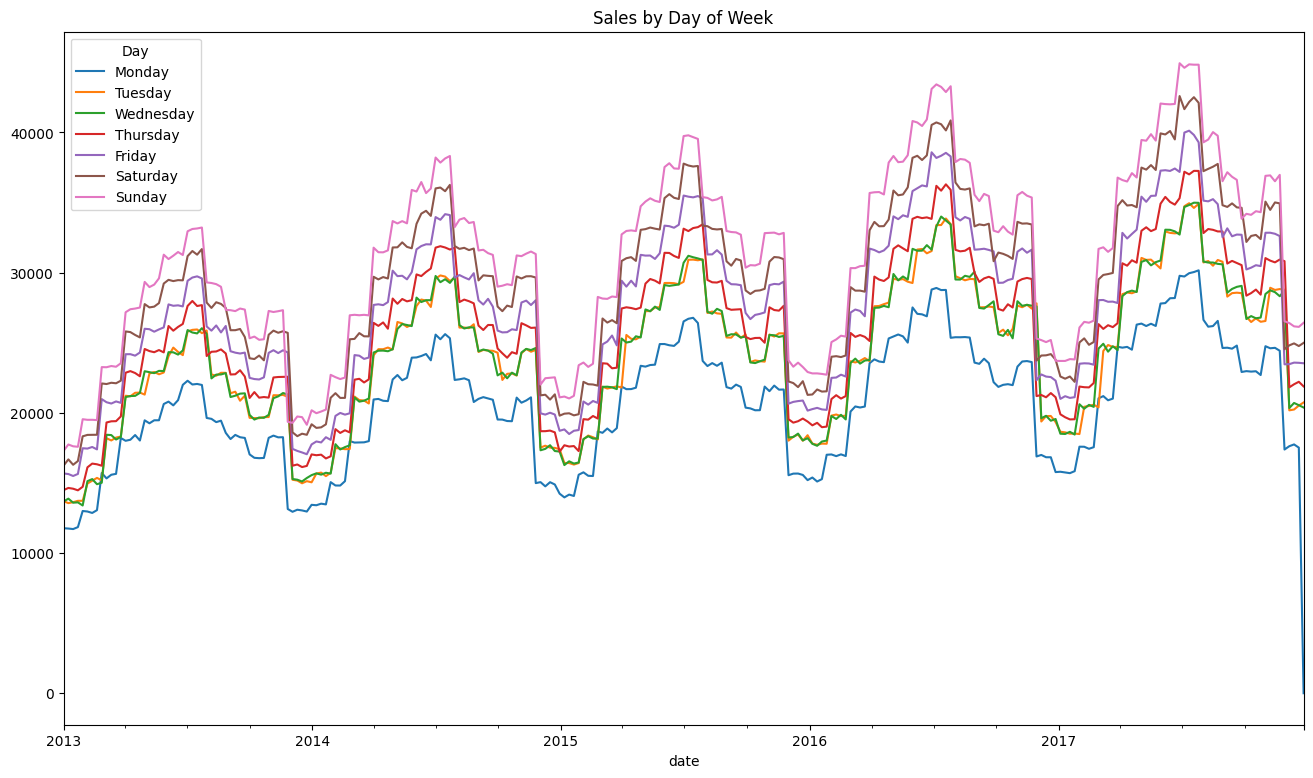

In [223]:
dow.plot(figsize=(16,9), title='Sales by Day of Week')
plt.show()

**6. Traitement des dates:**

La colonne 'date' est convertie en type datetime à l'aide de la fonction `to_datetime` de Pandas. Ensuite, de nouvelles colonnes **'year', 'month' et 'day' sont créées à partir de la colonne 'date'.**

In [166]:
df_train.date  = pd.to_datetime(df_train.date, format='%Y-%m-%d')

In [167]:
df_train['year'] = df_train.date.dt.year
df_train['month']=df_train.date.dt.month
df_train['day']=df_train.date.dt.day

In [168]:
df_test.date  = pd.to_datetime(df_test.date, format='%Y-%m-%d')
df_test['year'] = df_test.date.dt.year
df_test['month']=df_test.date.dt.month
df_test['day']=df_test.date.dt.day

- Suppression de la colonne 'date':
La colonne '*date*' est supprimée du DataFrame d'entraînement car elle n'est plus nécessaire après la création des colonnes '*year*', '*month*' et '*day*'.

In [169]:
df_train=df_train.drop(columns='date',axis=1)

**7. Conversion en colonnes catégorielles:**

Les colonnes '*year*', '*month*', '*day*', '*store*' et '*item*' sont converties en type catégoriel à l'aide de la méthode` astype`.
Cela permet de les traiter comme des variables catégorielles dans les analyses ultérieures.

In [170]:
df_train['year']=df_train['year'].astype('category')
df_train['month']=df_train['month'].astype('category')
df_train['day']=df_train['day'].astype('category')
df_train['store']=df_train['store'].astype('category')
df_train['item']=df_train['item'].astype('category')
df_train['sales']=df_train['sales'].astype('category')



La propriété `dtypes` est utilisée pour vérifier **les types de données** de chaque colonne du DataFrame d'entraînement.

In [171]:
df_train.dtypes

,0
store,category
item,category
sales,category
year,category
month,category
day,category


**8. Séparation de la variable cible:**

La colonne 'sales' est extraite du DataFrame d'entraînement et stockée dans un nouveau DataFrame `y`. **Cela permet de séparer la variable cible des variables explicatives**.

In [172]:
y=pd.DataFrame()
y['sales']=df_train['sales']
df_train=df_train.drop(columns='sales',axis=1)

In [173]:
df_train.head(10)

,store,item,year,month,day
0,1,1,2013,1,1
1,1,1,2013,1,2
2,1,1,2013,1,3
3,1,1,2013,1,4
4,1,1,2013,1,5
5,1,1,2013,1,6
6,1,1,2013,1,7
7,1,1,2013,1,8
8,1,1,2013,1,9
9,1,1,2013,1,10


**Modélisation avec le classificateur Random Forest**

 Cette étape utilise les données préparées lors des étapes précédentes pour entraîner un modèle de Random Forest. La sélection des caractéristiques et le traitement des données ont été effectués pour optimiser la performance du modèle.


In [174]:
clf = RandomForestClassifier(max_depth=2, random_state=0)


In [175]:
x=df_train.iloc[:,0:5] #Splitting input features

In [176]:
clf=clf.fit(x,y)    #Training with RF

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


 Importance des caractéristiques

 Cette étape analyse le modèle de Random Forest entraîné pour déterminer l'importance relative de chaque caractéristique. Cela permet de comprendre les facteurs qui influencent le plus les ventes.

In [177]:
for name, importance in zip(df_train.columns, clf.feature_importances_):
    print(name, "=", importance)

store = 0.13709824660288825
item = 0.5670258441164927
year = 0.04904195678595184
month = 0.24677815329641
day = 5.5799198257052335e-05


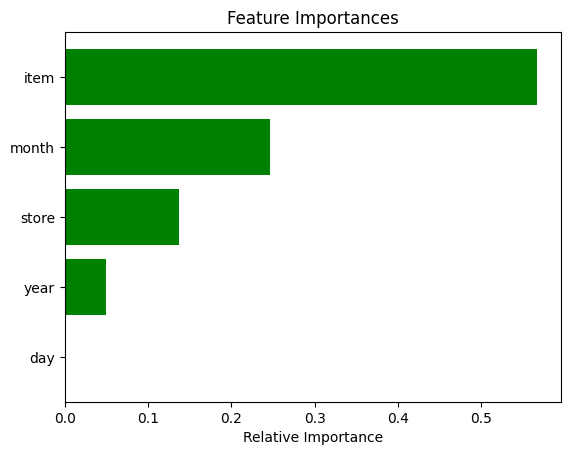

In [178]:
features =df_train.columns
importances =clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

**L'analyse des facteurs influençant les ventes** met en évidence que **le type d'article vendu est le critère le plus déterminant (0.567)**, ce qui paraît logique, certains produits se vendant mieux que d'autres. **La saisonnalité** joue également un rôle clé, avec **le mois de l'année comme deuxième facteur d'importance (0.246)**, suggérant des variations de ventes selon les périodes. **Le magasin** où l'article est vendu a aussi un impact notable** (0.137)**, bien que moindre, ce qui pourrait s'expliquer par des différences de localisation ou de clientèle. En revanche, l'année (0.049) semble avoir une influence plus faible, ce qui pourrait indiquer une certaine stabilité des tendances ou un manque de recul temporel dans les données. Enfin, le jour du mois (0.000055) apparaît comme un facteur négligeable, confirmant qu’il n’a pratiquement aucun effet sur les ventes.

**Distributions des ventes :**

In [ ]:
#converting into date format
df_train1.date  = pd.to_datetime(df_train1.date, format='%Y-%m-%d')
df_train1['year'] =df_train1.date.dt.year
df_train1['month']=df_train1.date.dt.month
df_train1['day']=df_train1.date.dt.day

**Analyser les ventes en fonction du magasin et de l'article.** : Tableaux croisés dynamiques

 Cette étape utilise des tableaux croisés dynamiques pour agréger les ventes en fonction de différentes dimensions. Cela permet de comparer les performances des ventes entre les magasins et les articles.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Création de la pivot table en excluant 'date'
sales_pivoted_df = pd.pivot_table(store_df, index='store', values='sales', columns='item', aggfunc="mean")

# Convertir en float pour éviter les erreurs
sales_pivoted_df = sales_pivoted_df.astype(float)

# Récupérer la liste complète des articles
all_items = sales_pivoted_df.columns

# Définir le nombre de graphiques et la taille des groupes (10 articles par graphique)
num_graphs = 5
items_per_graph = 10

# Générer les graphiques
for i in range(num_graphs):
    # Sélectionner 10 articles à chaque itération
    selected_items = all_items[i * items_per_graph : (i + 1) * items_per_graph]

    # Créer une nouvelle figure
    plt.figure(figsize=(12, 6))

    # Tracer les courbes pour ces articles
    sales_pivoted_df[selected_items].plot(ax=plt.gca(), linewidth=2)

    # Ajouter des titres et labels
    plt.title(f'Évolution des ventes moyennes (Articles {i*items_per_graph+1} à {(i+1)*items_per_graph})', fontsize=14)
    plt.xlabel('Magasin', fontsize=12)
    plt.ylabel('Ventes moyennes', fontsize=12)
    plt.legend(title='Article', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajouter une grille pour la lisibilité
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Afficher le graphique
    plt.show()


Pivot table month distributions

**Analyser les ventes en fonction du mois et du jour:** Distributions mensuelles du tableau croisé dynamique



In [ ]:
pivoted = pd.pivot_table(df_train1, values='sales' , columns='month', index='day')
pivoted.plot(figsize=(12,12));

On observe des fluctuations cycliques avec des pics et des creux réguliers, suggérant un effet hebdomadaire. Les mois en fin d’année affichent globalement des ventes plus élevées que les premiers mois, indiquant une possible saisonnalité. Cette analyse permet d’identifier les périodes de forte et de faible activité, précieuse pour l’optimisation des stocks et des stratégies commerciales.

Store Trends

Here we're looking to see if there are any seasonality trends in the total store sales. We'll group by week so we can more clearly see trends in the plots.

In [ ]:

stores = pd.DataFrame(df_train1.groupby(['date', 'store']).sum()['sales']).unstack()

stores.index = pd.to_datetime(stores.index)
# Resample to weekly data
stores = stores.resample('7D', label='left').sum()

# Sort by index (date)
stores.sort_index(inplace=True)

# Plot weekly store sales
stores.plot(figsize=(16, 9), title='Weekly Store Sales', legend=None)  # legend=None removes legend
plt.show()

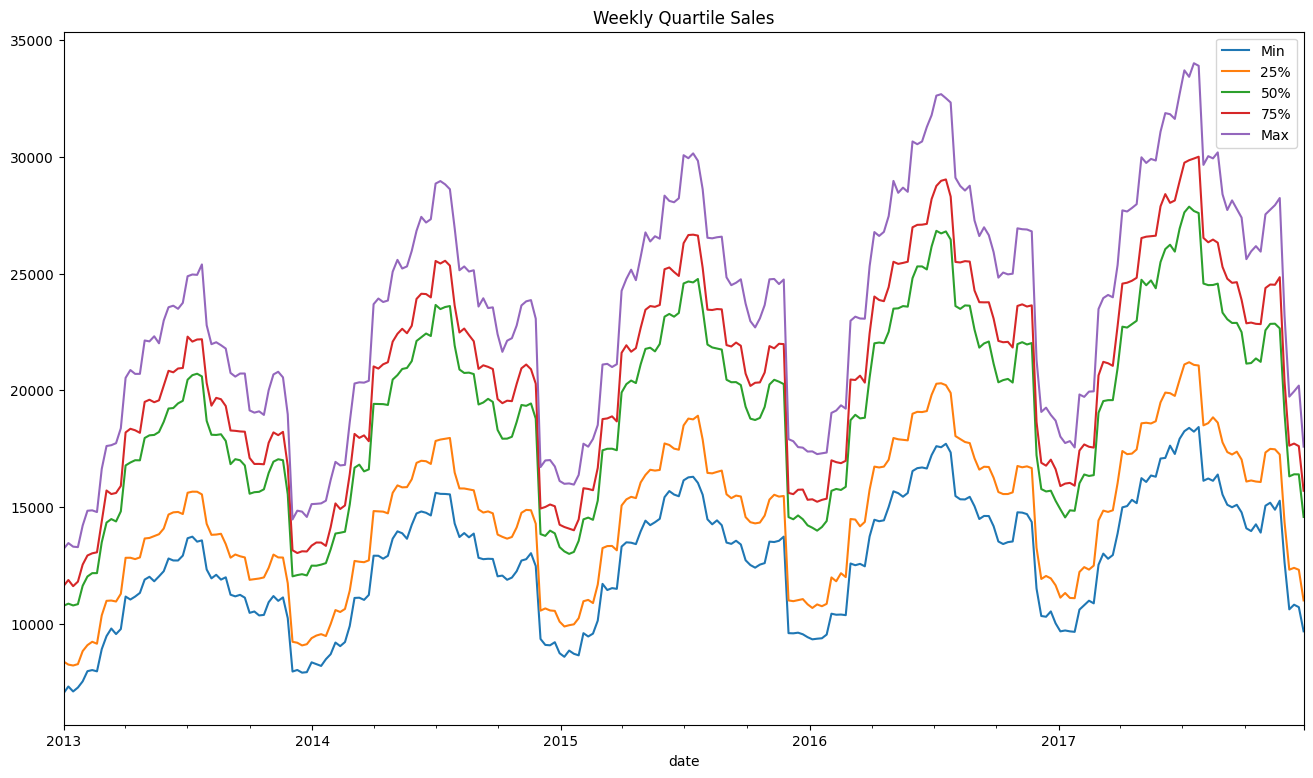

In [226]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0])
print(result)  # Print the results of the Augmented Dickey-Fuller test

Store Trends Conclusion


There is definitely seasonality in the store sales. Taking the week-to-week difference provides a dataset that is very likely to be stationary (< 1% chance that it's not). If we were to use this as a starting point for our model, we could cluster the stores to the nearest 25% quartile.

**Histogramme - Distribution des ventes :**

In [ ]:
df_train1.sales.hist(bins=100, figsize=(14,3))
plt.xlabel('Sales distribution')
plt.title('Histogram');

In [ ]:
df_train1['store'].value_counts()

In [ ]:
df_train1


# ***Correlation and similarity***

In [184]:
df_train

,store,item,year,month,day
0,1,1,2013,1,1
1,1,1,2013,1,2
2,1,1,2013,1,3
3,1,1,2013,1,4
4,1,1,2013,1,5
...,...,...,...,...,...
912995,10,50,2017,12,27
912996,10,50,2017,12,28
912997,10,50,2017,12,29
912998,10,50,2017,12,30


In [185]:
df_train1 = pd.read_csv('/content/train.csv')

In [186]:
import pandas as pd
import numpy as np

# On utilise vos DataFrames df_train et df_test
# Assurez-vous qu'ils sont chargés comme dans votre code initial
# df_train = pd.read_csv("/content/train.csv")
# df_test = pd.read_csv('/content/test.csv')

# Fusionner df_train et df_test pour l'analyse des ventes par magasin
df = pd.concat([df_train, df_test], sort=False)

# Augmentation de 56,25 % des ventes des magasins 5, 6 et 7 (facultatif)
# df.loc[df['store'].isin([5, 6, 7]), 'sales'] *= 1.5625

# Liste pour stocker les ventes des 10 magasins
liste_ventes_magasins = []

# Boucle pour extraire les ventes de chaque magasin
for i in range(1, 11):
    # Utiliser df_train1 ici
    ventes_magasin = df_train1[df_train1['store'] == i]['sales'].values
    liste_ventes_magasins.append(ventes_magasin)

# Calcul de la moyenne des ventes pour tous les magasins
ventes_moyennes = np.mean(liste_ventes_magasins)

# Calcul des corrélations entre les magasins
correlations_pearson = {}
for i in range(1, 11):
    for j in range(i + 1, 11):
        ventes_magasin_i = df_train1[df_train['store'] == i]['sales'].values
        ventes_magasin_j = df_train1[df_train['store'] == j]['sales'].values
        correlation = np.corrcoef(ventes_magasin_i, ventes_magasin_j)[0, 1]
        correlations_pearson[(i, j)] = correlation
        print(f"Corrélation de Pearson entre le Magasin {i} et le Magasin {j} : {correlation:.2f}")

Corrélation de Pearson entre le Magasin 1 et le Magasin 2 : 0.93
Corrélation de Pearson entre le Magasin 1 et le Magasin 3 : 0.93
Corrélation de Pearson entre le Magasin 1 et le Magasin 4 : 0.92
Corrélation de Pearson entre le Magasin 1 et le Magasin 5 : 0.91
Corrélation de Pearson entre le Magasin 1 et le Magasin 6 : 0.91
Corrélation de Pearson entre le Magasin 1 et le Magasin 7 : 0.91
Corrélation de Pearson entre le Magasin 1 et le Magasin 8 : 0.93
Corrélation de Pearson entre le Magasin 1 et le Magasin 9 : 0.92
Corrélation de Pearson entre le Magasin 1 et le Magasin 10 : 0.93
Corrélation de Pearson entre le Magasin 2 et le Magasin 3 : 0.94
Corrélation de Pearson entre le Magasin 2 et le Magasin 4 : 0.93
Corrélation de Pearson entre le Magasin 2 et le Magasin 5 : 0.92
Corrélation de Pearson entre le Magasin 2 et le Magasin 6 : 0.92
Corrélation de Pearson entre le Magasin 2 et le Magasin 7 : 0.92
Corrélation de Pearson entre le Magasin 2 et le Magasin 8 : 0.94
Corrélation de Pearson e

Les corrélations de Pearson entre les magasins indiquent une forte relation positive entre leurs ventes ou comportements, avec des valeurs proches de 1 dans la majorité des paires analysées. Cela suggère que les performances des magasins sont étroitement liées, probablement en raison de facteurs communs comme les tendances du marché, la localisation ou des stratégies de vente similaires. Par exemple, les corrélations entre le Magasin 1 et les autres magasins, qui varient de 0.91 à 0.93, montrent une très forte similarité dans leurs résultats. Le Magasin 2 affiche également des corrélations élevées, atteignant 0.94 avec plusieurs autres magasins, ce qui renforce l'idée de comportements semblables entre ces points de vente. Les corrélations légèrement plus faibles (autour de 0.90) entre certains magasins, comme entre le Magasin 5 et le Magasin 6, peuvent suggérer une relation un peu moins forte, mais demeurent significatives. Globalement, ces corrélations indiquent une homogénéité importante dans les performances des magasins, ce qui pourrait influencer des décisions stratégiques communes telles que les promotions, les assortiments de produits ou les horaires d'ouverture.

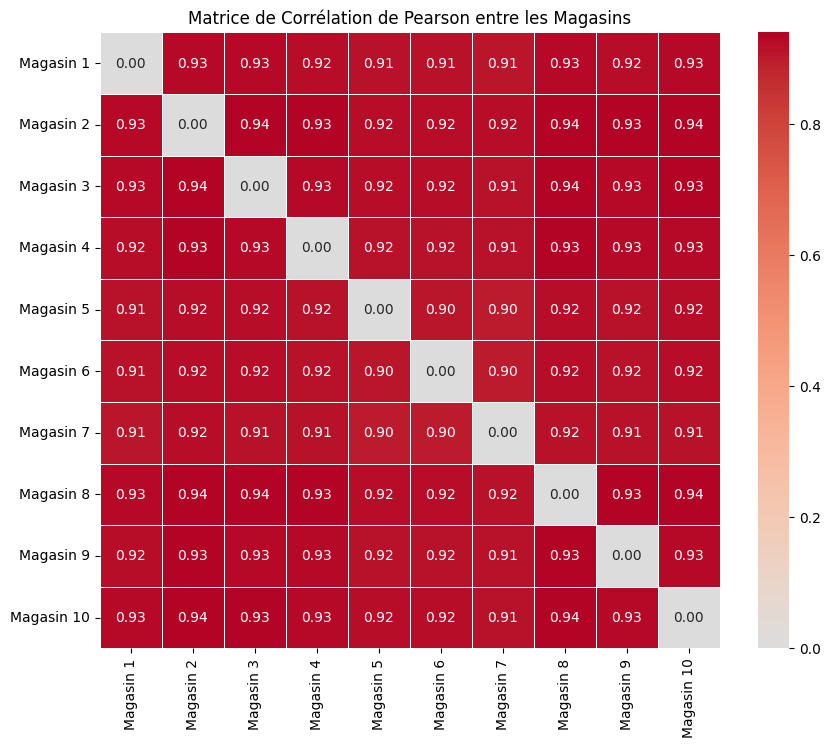

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer une matrice de corrélation
corr_matrix = np.zeros((10, 10))

# Remplir la matrice avec les valeurs de corrélation
for i in range(10):
    for j in range(i + 1, 10):
        corr_matrix[i, j] = correlations_pearson[(i+1, j+1)]
        corr_matrix[j, i] = correlations_pearson[(i+1, j+1)]  # Symétrique

# Créer un DataFrame pour mieux organiser et afficher les corrélations
corr_df = pd.DataFrame(corr_matrix, columns=[f'Magasin {i+1}' for i in range(10)],
                       index=[f'Magasin {i+1}' for i in range(10)])

# Visualiser la matrice de corrélation avec un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation de Pearson entre les Magasins")
plt.show()


In [188]:
import pandas as pd
import numpy as np

average_sales = df_train1.groupby('date')['sales'].mean().values

# Dictionnaire pour stocker les corrélations
pearson_correlations_with_avg = {}

# Calcul du coefficient de corrélation entre chaque magasin et les ventes moyennes
for i in range(1, 11):
    store_sales = df_train1[df_train1['store'] == i].set_index('date')['sales'].values
    # Assurer la même longueur pour store_sales et average_sales
    min_length = min(len(store_sales), len(average_sales))
    correlation = np.corrcoef(store_sales[:min_length], average_sales[:min_length])[0, 1]
    pearson_correlations_with_avg[i] = correlation
    print(f"Corrélation de Pearson entre le Magasin {i} et les ventes moyennes de tous les magasins : {correlation:.2f}")

Corrélation de Pearson entre le Magasin 1 et les ventes moyennes de tous les magasins : 0.76
Corrélation de Pearson entre le Magasin 2 et les ventes moyennes de tous les magasins : 0.80
Corrélation de Pearson entre le Magasin 3 et les ventes moyennes de tous les magasins : 0.78
Corrélation de Pearson entre le Magasin 4 et les ventes moyennes de tous les magasins : 0.76
Corrélation de Pearson entre le Magasin 5 et les ventes moyennes de tous les magasins : 0.69
Corrélation de Pearson entre le Magasin 6 et les ventes moyennes de tous les magasins : 0.70
Corrélation de Pearson entre le Magasin 7 et les ventes moyennes de tous les magasins : 0.68
Corrélation de Pearson entre le Magasin 8 et les ventes moyennes de tous les magasins : 0.78
Corrélation de Pearson entre le Magasin 9 et les ventes moyennes de tous les magasins : 0.78
Corrélation de Pearson entre le Magasin 10 et les ventes moyennes de tous les magasins : 0.78


Les corrélations de Pearson entre chaque magasin et les ventes moyennes de tous les magasins révèlent des relations modérées à fortes, mais avec des variations intéressantes. Voici une interprétation détaillée :

Magasins 2, 3, 8, 9, et 10 affichent des corrélations relativement élevées (autour de 0.78), ce qui signifie que leurs performances sont assez bien alignées avec la moyenne des ventes des 10 magasins. Cela suggère que ces magasins suivent une tendance similaire aux ventes globales et bénéficient probablement de facteurs communs influençant les ventes.

Magasins 1, 4 ont des corrélations légèrement plus faibles (0.76), ce qui montre également une forte relation avec les ventes moyennes, bien qu'elles soient légèrement moins marquées que pour les magasins mentionnés ci-dessus.

Magasins 5, 6, et 7 ont des corrélations plus faibles, autour de 0.69 à 0.70, ce qui indique une relation un peu plus modeste avec les ventes moyennes. Ces magasins peuvent avoir des comportements différents des autres, et leurs performances pourraient être influencées par des facteurs particuliers, comme la localisation ou des campagnes spécifiques.

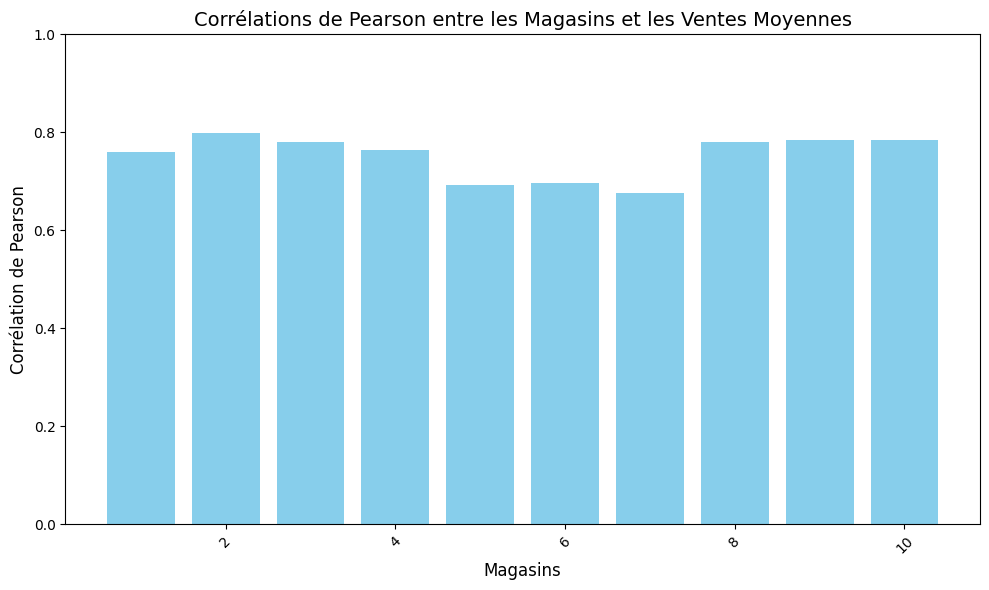

In [189]:
import matplotlib.pyplot as plt

# Dictionnaire des corrélations de Pearson
pearson_correlations_with_avg = {}

# Calcul du coefficient de corrélation entre chaque magasin et les ventes moyennes
for i in range(1, 11):
    store_sales = df_train1[df_train1['store'] == i].set_index('date')['sales'].values
    # Assurer la même longueur pour store_sales et average_sales
    min_length = min(len(store_sales), len(average_sales))
    correlation = np.corrcoef(store_sales[:min_length], average_sales[:min_length])[0, 1]
    pearson_correlations_with_avg[i] = correlation

# Visualiser les corrélations sous forme de bar plot
plt.figure(figsize=(10, 6))
plt.bar(pearson_correlations_with_avg.keys(), pearson_correlations_with_avg.values(), color='skyblue')

# Ajouter des titres et des labels
plt.title("Corrélations de Pearson entre les Magasins et les Ventes Moyennes", fontsize=14)
plt.xlabel("Magasins", fontsize=12)
plt.ylabel("Corrélation de Pearson", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Les corrélations sont comprises entre 0 et 1

# Afficher le graphique
plt.tight_layout()
plt.show()


In [190]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# ... (votre code précédent pour charger df_train, df_test, df_train1, etc.)

# Calcul de la similarité cosinus entre chaque paire de magasins
cosine_similarities = {}
for i in range(1, 11):
    for j in range(i + 1, 11):
        # Utiliser df_train1 ici
        store_i_sales = df_train1[df_train1['store'] == i].set_index('date')['sales'].values.reshape(1, -1)
        store_j_sales = df_train1[df_train1['store'] == j].set_index('date')['sales'].values.reshape(1, -1)

        # Calcul de la similarité cosinus
        similarity = cosine_similarity(store_i_sales, store_j_sales)[0, 0]
        cosine_similarities[(i, j)] = similarity
        print(f"Similarité cosinus entre le Magasin {i} et le Magasin {j}: {similarity:.2f}")

Similarité cosinus entre le Magasin 1 et le Magasin 2: 0.99
Similarité cosinus entre le Magasin 1 et le Magasin 3: 0.98
Similarité cosinus entre le Magasin 1 et le Magasin 4: 0.98
Similarité cosinus entre le Magasin 1 et le Magasin 5: 0.98
Similarité cosinus entre le Magasin 1 et le Magasin 6: 0.98
Similarité cosinus entre le Magasin 1 et le Magasin 7: 0.98
Similarité cosinus entre le Magasin 1 et le Magasin 8: 0.99
Similarité cosinus entre le Magasin 1 et le Magasin 9: 0.98
Similarité cosinus entre le Magasin 1 et le Magasin 10: 0.98
Similarité cosinus entre le Magasin 2 et le Magasin 3: 0.99
Similarité cosinus entre le Magasin 2 et le Magasin 4: 0.99
Similarité cosinus entre le Magasin 2 et le Magasin 5: 0.98
Similarité cosinus entre le Magasin 2 et le Magasin 6: 0.98
Similarité cosinus entre le Magasin 2 et le Magasin 7: 0.98
Similarité cosinus entre le Magasin 2 et le Magasin 8: 0.99
Similarité cosinus entre le Magasin 2 et le Magasin 9: 0.99
Similarité cosinus entre le Magasin 2 e

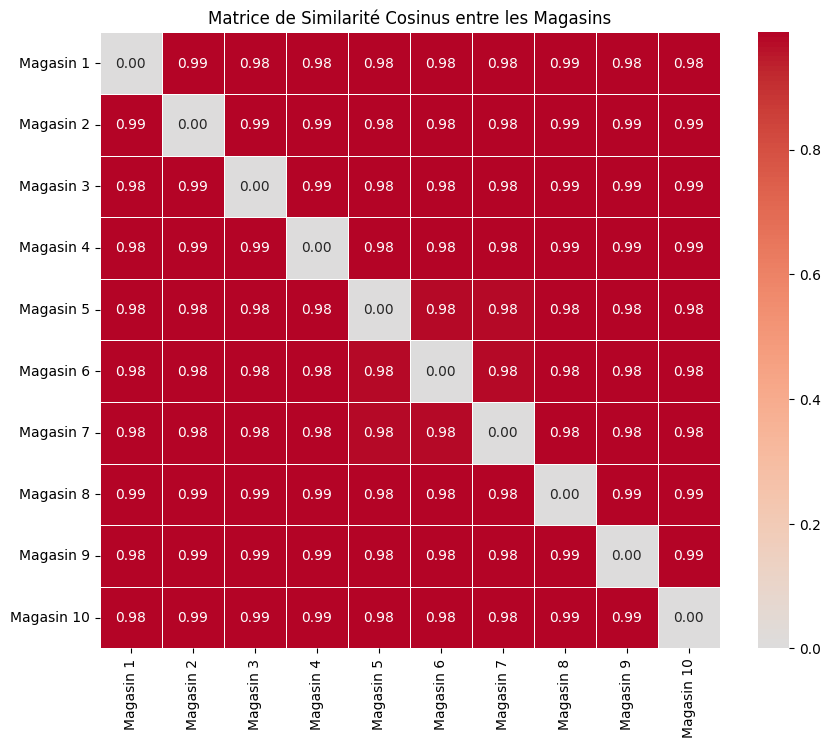

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer une matrice de similarité
similarity_matrix = np.zeros((10, 10))

# Remplir la matrice avec les similarités cosinus
for i in range(1, 11):
    for j in range(i + 1, 11):
        similarity_matrix[i-1, j-1] = cosine_similarities[(i, j)]
        similarity_matrix[j-1, i-1] = cosine_similarities[(i, j)]  # Symétrique

# Créer un DataFrame pour mieux organiser et afficher les similarités
similarity_df = pd.DataFrame(similarity_matrix, columns=[f'Magasin {i}' for i in range(1, 11)],
                              index=[f'Magasin {i}' for i in range(1, 11)])

# Visualiser la matrice de similarité avec un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title("Matrice de Similarité Cosinus entre les Magasins")
plt.show()


Les résultats montrent que les magasins sont fortement similaires les uns aux autres, avec des valeurs de similarité cosinus proches de 1 (entre 0.98 et 0.99) pour presque toutes les paires de magasins. Cela suggère que les tendances de ventes sont très similaires entre les magasins, ce qui peut indiquer une uniformité dans les comportements de consommation ou des facteurs externes influençant tous les magasins de manière similaire. Ces similarités élevées peuvent aussi signaler des stratégies de vente communes ou une gestion centralisée.

In [31]:
dataset = pd.read_csv('/content/1train.csv')
df = dataset.copy()

In [41]:
def load_data(file_name):
    """Returns a pandas dataframe from a csv file."""
    return pd.read_csv(file_name)

In [42]:
sales_data = load_data('/content/1train.csv')
df_s = sales_data.copy()
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [43]:
def monthlyORyears_sales(data,time=['monthly','years']):
    data = data.copy()
    if time == "monthly":
        # Drop the day indicator from the date column:
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])

   # Sum sales per month:
    data = data.groupby('date')['sales'].sum().reset_index()
    data.date = pd.to_datetime(data.date)

    return data

In [44]:
m_df = monthlyORyears_sales(df_s,"monthly")

m_df.to_csv('./monthly_data.csv')

In [36]:
def get_diff(data):
    """Calculate the difference in sales month over month:"""

    data['sales_diff'] = data.sales.diff()
    data = data.dropna()

    data.to_csv('./stationary_df.csv')

    return data

In [45]:
m_df.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


In [47]:
y_df = monthlyORyears_sales(df_s,"years")
y_df

,date,sales
0,2013-01-01,7941243
1,2014-01-01,9135482
2,2015-01-01,9536887
3,2016-01-01,10357160
4,2017-01-01,10733740


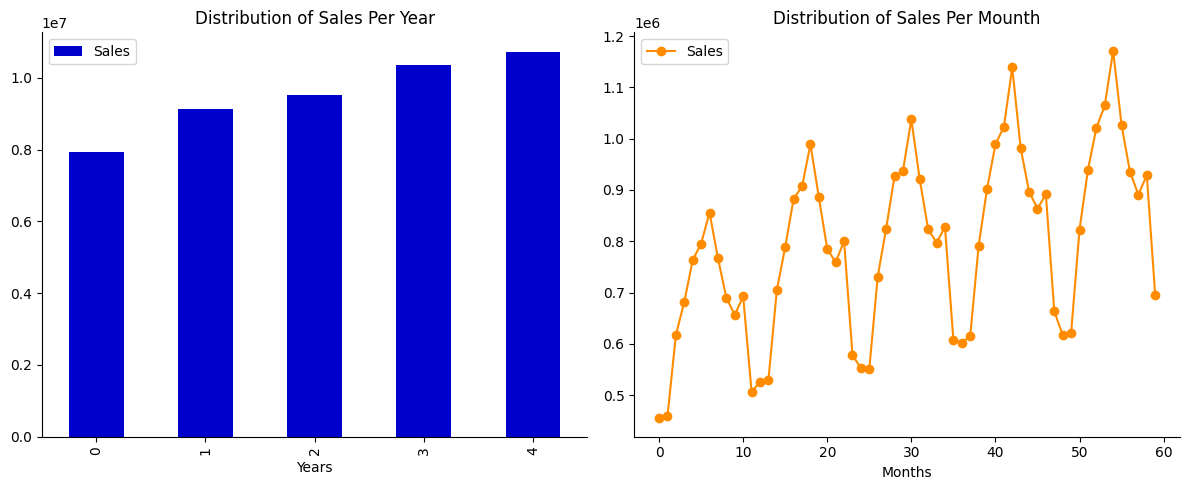

In [48]:
layout = (1, 2)

raw = plt.subplot2grid(layout, (0 ,0))
law = plt.subplot2grid(layout, (0 ,1))

years = y_df['sales'].plot(kind = "bar",color = 'mediumblue', label="Sales",ax=raw, figsize=(12,5))
months = m_df['sales'].plot(marker = 'o',color = 'darkorange', label="Sales", ax=law)

years.set(xlabel = "Years",title = "Distribution of Sales Per Year")
months.set(xlabel = "Months", title = "Distribution of Sales Per Mounth")

sns.despine()
plt.tight_layout()

years.legend()
months.legend()

In [49]:
def sales_time(data):
    """Time interval of dataset:"""

    data.date = pd.to_datetime(data.date)
    n_of_days = data.date.max() - data.date.min()
    n_of_years = int(n_of_days.days / 365)

    print(f"Days: {n_of_days.days}\nYears: {n_of_years}\nMonth: {12 * n_of_years}")

In [50]:
sales_time(df_s)

Days: 1825
Years: 5
Month: 60


In [51]:
# Let's sell it per store:

def sales_per_store(data):
    sales_by_store = data.groupby('store')['sales'].sum().reset_index()

    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(sales_by_store.store, sales_by_store.sales, color='darkred')

    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")

    return sales_by_store


In [53]:
# Overall for 5 years:

average_m_sales = m_df.sales.mean()
print(f"Overall Avarage Monthly Sales: ${average_m_sales}")

def avarage_12months():
# Last 1 years (this will be the forecasted sales):
    average_m_sales_1y = m_df.sales[-12:].mean()
    print(f"Last 12 months average monthly sales: ${average_m_sales_1y}")
avarage_12months()

Overall Avarage Monthly Sales: $795075.2
Last 12 months average monthly sales: $894478.3333333334


# Modélisation avec ARIMA

In [54]:
def build_arima_data(data):
    """Generates a csv-file with a datetime index and a dependent sales column for ARIMA modeling."""

    da_data = data.set_index('date').drop('sales', axis=1)
    da_data.dropna(axis=0)

    da_data.to_csv('./arima_df.csv')

    return da_data

In [55]:
datatime_df = build_arima_data(stationary_df)
datatime_df # ARIMA Dataframe

,sales_diff
date,
2013-02-01,4513.0
2013-03-01,157965.0
2013-04-01,64892.0
2013-05-01,80968.0
2013-06-01,32355.0
2013-07-01,60325.0
2013-08-01,-89161.0
2013-09-01,-76854.0
2013-10-01,-33320.0


Pour nos autres modèles, nous créerons un nouveau DataFrame où chaque caractéristique représente les ventes des mois précédents. Pour déterminer combien de mois inclure dans notre ensemble de caractéristiques, nous observerons les graphiques d'autocorrélation et d'autocorrélation partielle, et utiliserons les règles de sélection des retards dans la modélisation ARIMA. Ainsi, nous pourrons maintenir une période de rétrospection cohérente pour nos modèles ARIMA et régressifs.

In [57]:
import statsmodels.tsa.api as smt

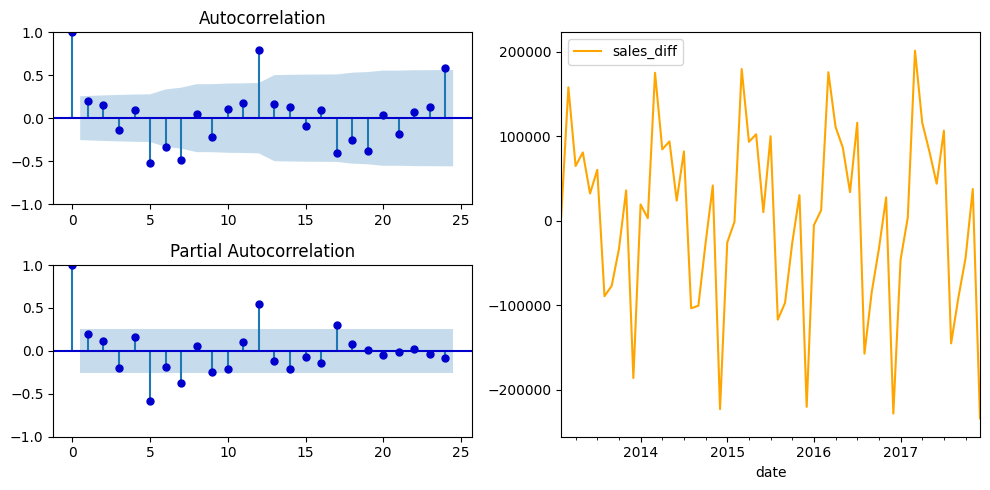

In [58]:
def plots_lag(data, lags=None):
    """Convert dataframe to datetime index"""
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)


    law  = plt.subplot(122)
    acf  = plt.subplot(221)
    pacf = plt.subplot(223)

    dt_data.plot(ax=law, figsize=(10, 5), color='orange')
    # Plot the autocorrelation function:
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')

    # Will also adjust spacing between subplots to minimize the overlaps:
    plt.tight_layout()

plots_lag(stationary_df, lags=24);



# Modélisation Régressive

Créons un fichier CSV où chaque ligne représente un mois, et les colonnes contiendront les ventes, les variables dépendantes, ainsi que les ventes des mois précédents pour chaque retard. Les 12 propriétés de retard sont générées selon l’analyse exploratoire des données (EDA). Ces données seront ensuite utilisées pour la modélisation régressive.

In [59]:
def built_supervised(data):
    supervised_df = data.copy()


    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)


    supervised_df = supervised_df.dropna().reset_index(drop=True)

    supervised_df.to_csv('./model_df.csv', index=False)

    return supervised_df

In [60]:
model_df = built_supervised(stationary_df)
model_df

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2014-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2014-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2014-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2014-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2014-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


# **Fonctions pour la Modélisation**
Pour créer et évaluer tous nos modèles, nous utiliserons une série de fonctions auxiliaires qui accompliront les tâches suivantes :

# **Séparation des ensembles d'entraînement et de test**
Mise à l’échelle des données
Inverse de la mise à l’échelle
Création d'un DataFrame pour les prédictions
Évaluation des modèles
Séparation des Entraînements et Tests
Nous séparons nos données de manière à ce que les 12 derniers mois fassent partie de l'ensemble de test, tandis que le reste des données est utilisé pour entraîner notre modèle.

In [62]:
def train_test_split(data):
    data = data.drop(['sales','date'], axis=1)
    train , test = data[:-12].values, data[-12:].values

    return train, test

train, test = train_test_split(model_df)
print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}")

Shape of  Train: (35, 13)
Shape of  Test: (12, 13)


**Mise à l'échelle des données**
Nous utiliserons un scaler Min-Max pour mettre à l’échelle les données, de sorte que toutes nos variables se situent dans la plage de -1 à 1. Cette transformation permet de standardiser les caractéristiques et d'améliorer la performance des modèles, notamment pour ceux qui sont sensibles à l'échelle des données, comme les réseaux de neurones et la régression.

In [64]:
from sklearn.preprocessing import MinMaxScaler


In [65]:
def scale_data(train_set,test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test."""

    # Apply Min Max Scaler:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # Reshape training set:
    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # Reshape test set:
    test_set = test_set.reshape(test_set.shape[0],
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() # returns the array, flattened!
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()

    return X_train, y_train, X_test, y_test, scaler


X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")

Shape of X Train: (35, 12)
Shape of y Train: (35,)
Shape of X Test: (12, 12)
Shape of y Test: (12,)


**Inversion de la Mise à l'Échelle**

Après avoir exécuté nos modèles, nous utiliserons cette fonction auxiliaire pour inverser la mise à l'échelle effectuée à l'étape 2. Cela permettra de revenir aux valeurs originales des ventes ou des variables dépendantes, facilitant ainsi l'interprétation des résultats dans le contexte des données d'origine.

In [66]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    y_pred = y_pred.reshape(y_pred.shape[0],
                            1,
                            1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0],
                                1,
                                x_test.shape[1])

    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],
                                             x_test[index]],
                                             axis=1) )

    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted

# **DataFrame des Prédictions**

Nous générerons un DataFrame contenant les ventes réelles issues de notre ensemble de test, ainsi que les résultats prédits par notre modèle. Cela nous permettra de quantifier la performance du modèle en comparant les valeurs observées aux valeurs prédites, et ainsi d’évaluer l'exactitude de nos prévisions.

In [83]:
def prediction_df(unscale_predictions, origin_df):
    result_list = []
    sales_dates = list(origin_df[-13:].date)
    act_sales = list(origin_df[-13:].sales)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

# **Évaluation des Modèles**

Cette fonction auxiliaire enregistrera l'erreur quadratique moyenne (RMSE) et l'erreur absolue moyenne (MAE) de nos prédictions afin de comparer la performance de nos modèles. Ces métriques de régression nous permettront de mesurer la précision de nos modèles en termes de variation moyenne des prédictions par rapport aux valeurs réelles.

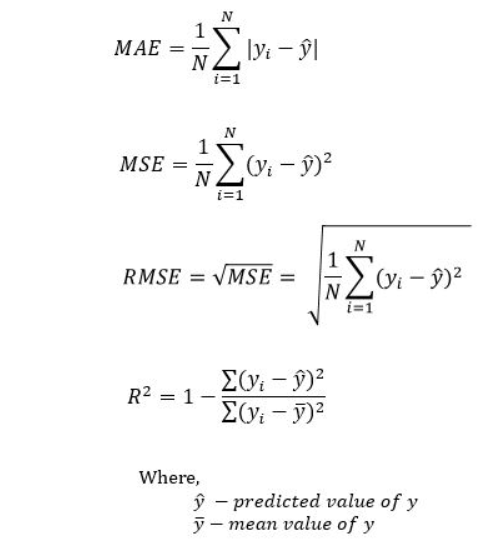

In [84]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):

    rmse = np.sqrt(mean_squared_error(origin_df.sales[-12:],
                                      unscale_df.pred_value[-12:]))

    mae = mean_absolute_error(origin_df.sales[-12:],
                              unscale_df.pred_value[-12:])

    r2 = r2_score(origin_df.sales[-12:],
                  unscale_df.pred_value[-12:])

    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

In [86]:
def plot_results(results, origin_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=origin_df.date, y=origin_df.sales, data=origin_df, ax=ax,
                 label='Original', color='blue')
    sns.lineplot(x=results.date, y=results.pred_value, data=results, ax=ax,
                 label='Predicted', color='red')


    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")

    ax.legend(loc='best')

    plt.show()  # Display the plot

In [87]:
def regressive_model(train_data, test_data, model, model_name):

    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data,
                                                                 test_data)

    # Run sklearn models:
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) # y_pred=predictions

    # Undo scaling to compare predictions against original data:
    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object) # unscaled_predictions
    unscaled_df = prediction_df(unscaled, origin_df)

    # Print scores and plot results:
    get_scores(unscaled_df, origin_df, model_name)
    plot_results(unscaled_df, origin_df, model_name)


# **Modèles Régressifs**

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


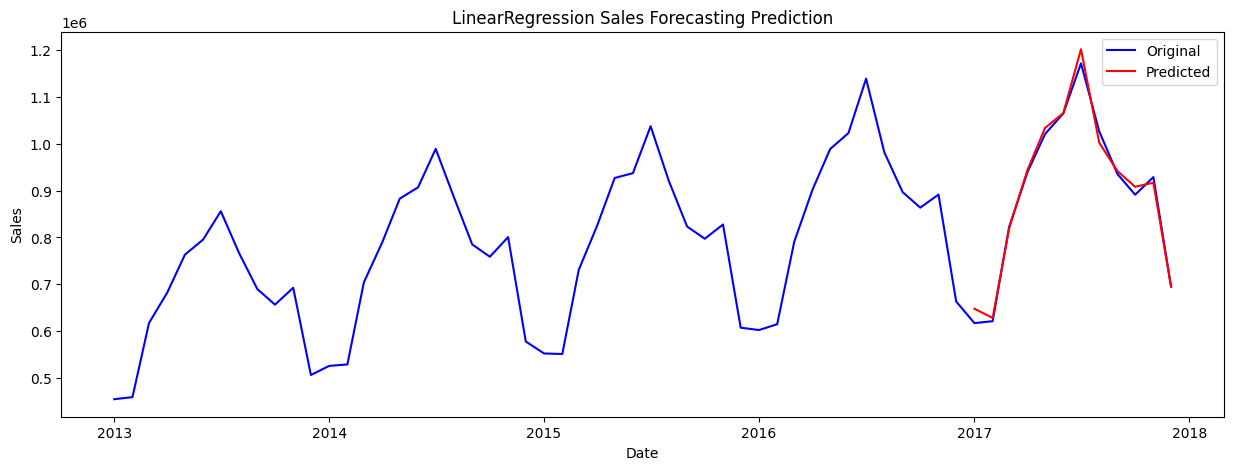

In [88]:
regressive_model(train, test, LinearRegression(), 'LinearRegression')

# Forêt Aléatoire pour la Régression (Random Forest Regressor)

RMSE: 17683.211571996755
MAE: 14478.5
R2 Score: 0.9889663485904567


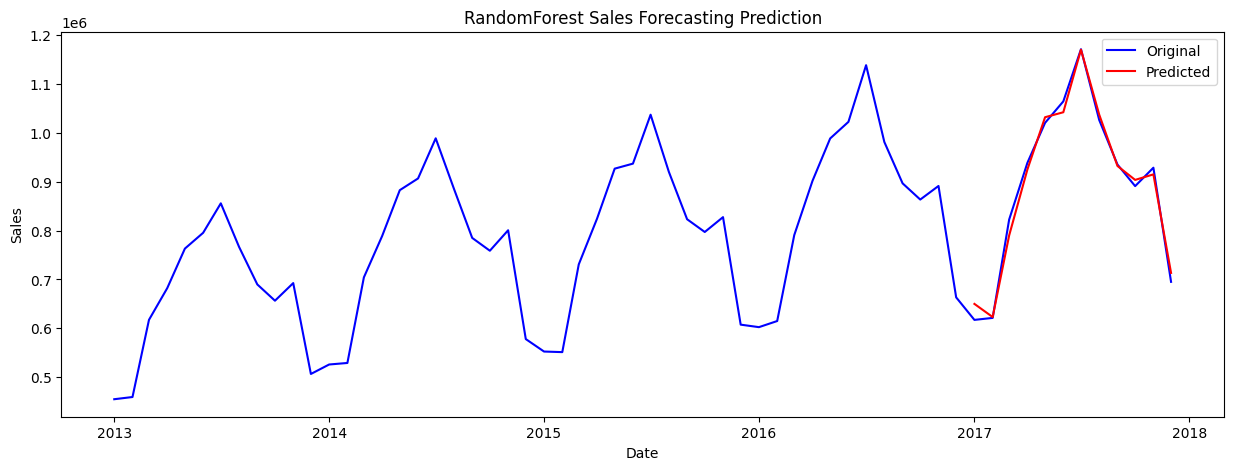

In [91]:
regressive_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20),
          'RandomForest')

# **XGBoost**

In [93]:
from xgboost import XGBRegressor


RMSE: 22730.366245766185
MAE: 18379.166666666668
R2 Score: 0.9817690273475503


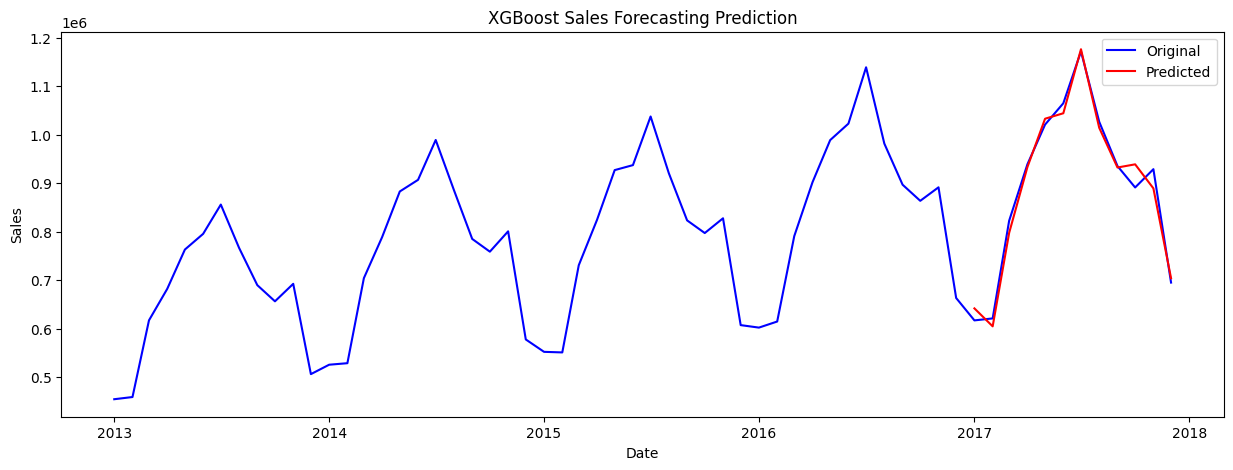

In [94]:
regressive_model(train, test, XGBRegressor(n_estimators=100,max_depth=3,
                                           learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')

# **LSTM (Long Short-Term Memory)**

In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

In [134]:
def lstm_model(train_data, test_data, batch_size=1):
    """Runs a long-short-term-memory neural net with 2 dense layers.
    Generates predictions that are then unscaled.
    Scores are printed and the results are plotted and saved."""

    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data, batch_size)

    # Build LSTM (no need to reshape here anymore):
    model = Sequential()
    model.add(Input(batch_shape=(batch_size, X_train.shape[1], X_train.shape[2])))  # Input layer with batch_shape
    model.add(LSTM(4, stateful=True))  # LSTM layer
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1, shuffle=False)

    # Make predictions
    predictions = model.predict(X_test, batch_size=batch_size)

    # Undo scaling
    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = prediction_df(unscaled, origin_df)

    # Evaluate and plot results
    get_scores(unscaled_df, origin_df, 'LSTM')
    plot_results(unscaled_df, origin_df, 'LSTM')

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 0.3405
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.2213
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.1742
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.1428
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.1200
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0276 - loss: 0.1023
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0276 - loss: 0.0882
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0276 - loss: 0.0765
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0276 - loss: 0.0669
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0276 - loss: 0.0587
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0276 - loss: 0.0518
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

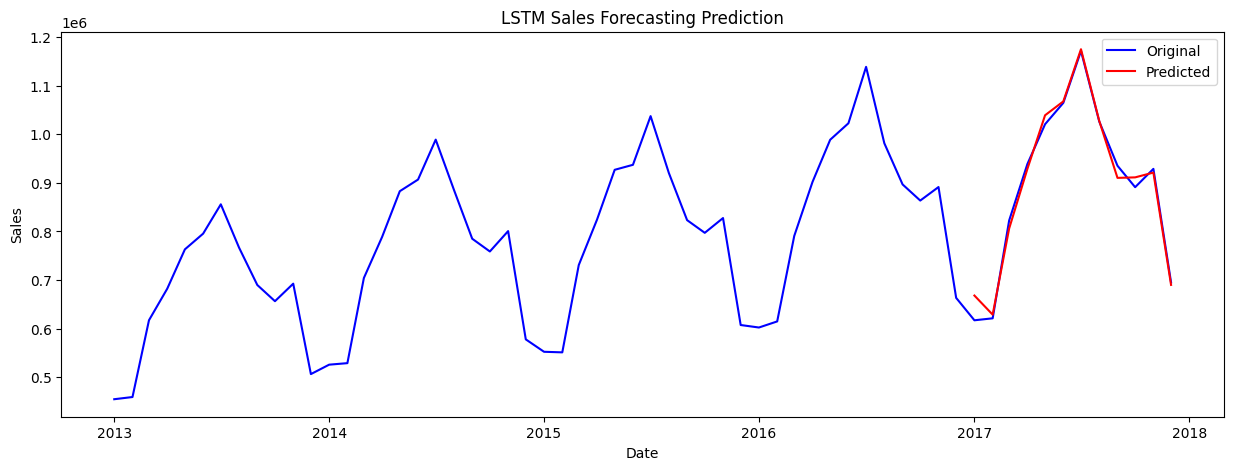

In [133]:
lstm_model(train,test)

# **Comparing Models**

In [154]:
def create_results_df():
    results_dict = pickle.load(open("model_scores.p", "rb"))

    results_dict.update(pickle.load(open("ARIMAmodel_scores.p", "rb")))

    results_df = pd.DataFrame.from_dict(results_dict, orient='index',
                                        columns=['RMSE', 'MAE','R2'])

    results_df = results_df.sort_values(by='RMSE', ascending=False).reset_index()

    results_df.to_csv('./results.csv')

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax,
                 label='RMSE', color='darkblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax,
                 label='MAE', color='Cyan')

    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model",
           ylabel = "Scores",
           title = "Model Error Comparison")
    sns.despine()

    plt.savefig(f'./model_output/compare_models.png')

    return results_df


             Modèle          RMSE           MAE        R²
0      RandomForest  17683.211000  14478.500000  0.988966
1              LSTM  19358.164304  14085.083333  0.986777
2  LinearRegression  16221.040791  12433.000000  0.990716
3             ARIMA  14959.893500  11265.335749  0.983500
4           XGBoost  22730.366200  18379.166660  0.981769


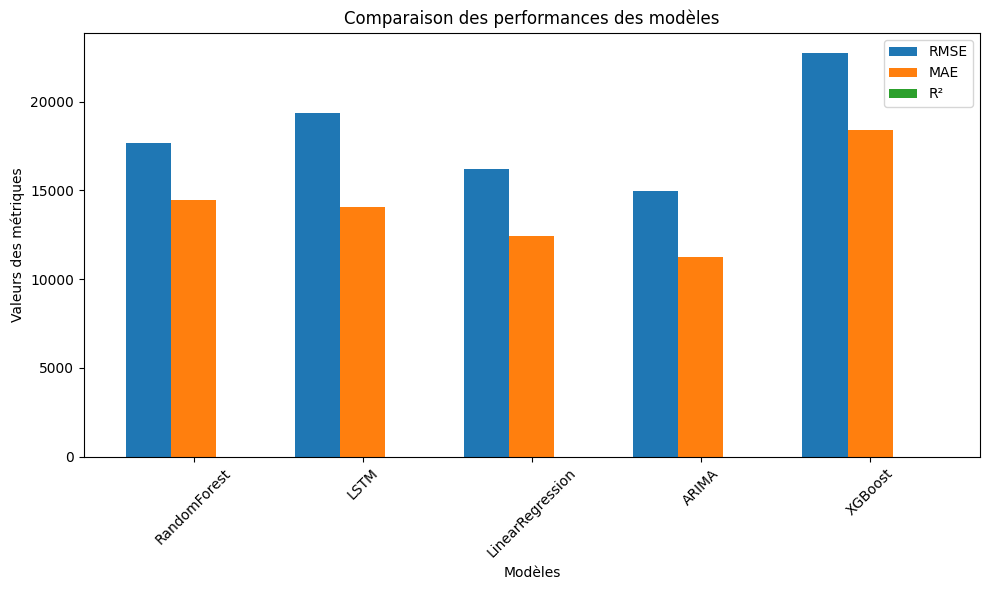

In [193]:
import pandas as pd
import matplotlib.pyplot as plt

# Création du DataFrame avec les performances des modèles
data = {
    "Modèle": ["RandomForest", "LSTM", "LinearRegression", "ARIMA", "XGBoost"],
    "RMSE": [17683.211, 19358.164304, 16221.040791, 14959.8935, 22730.3662],
    "MAE": [14478.5, 14085.0833333, 12433.000000, 11265.335749, 18379.16666],
    "R²": [0.98896634, 0.986777, 0.990716, 0.9835, 0.981769]
}

# Convertir les données en DataFrame
df = pd.DataFrame(data)

# Afficher le tableau
print(df)

# Visualisation des résultats
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer les barres pour RMSE, MAE, et R²
df.plot(x='Modèle', y=['RMSE', 'MAE', 'R²'], kind='bar', ax=ax, width=0.8)

# Ajouter des titres et labels
ax.set_title('Comparaison des performances des modèles')
ax.set_xlabel('Modèles')
ax.set_ylabel('Valeurs des métriques')
ax.set_xticklabels(df['Modèle'], rotation=45)
ax.legend(["RMSE", "MAE", "R²"])

# Afficher la courbe
plt.tight_layout()
plt.show()
